In [1]:
import sys
sys.path.append('../utils')
sys.path.append('../core')
sys.path.append('../')
import numpy as np
import scipy
import tqdm
import utils
import geometry
import phantom_builder
from core import *
import open3d as o3d
from open3d import io, visualization

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import glob
import pydicom
import functools

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
test_phantom = phantom.Phantom.load('hando_phantom')

In [3]:
test_phantom.matrix_dims

array([147, 229, 400])

In [4]:
test_phantom.get_complete().shape

(2, 147, 229, 400)

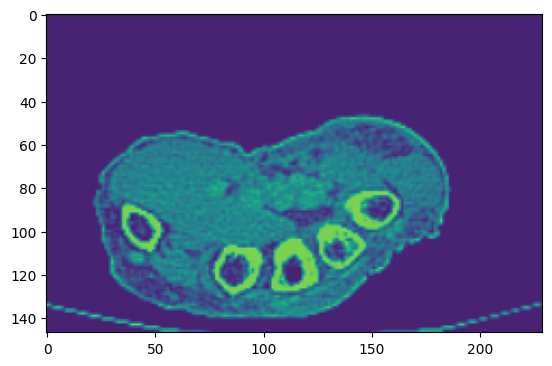

In [5]:
plt.imshow(test_phantom.get_complete()[0, :, :, 200], vmin=1500, vmax=2000)
# plt.imshow(body_mask[:,:, 250] * 1000, alpha=0.2, cmap='Reds_r')

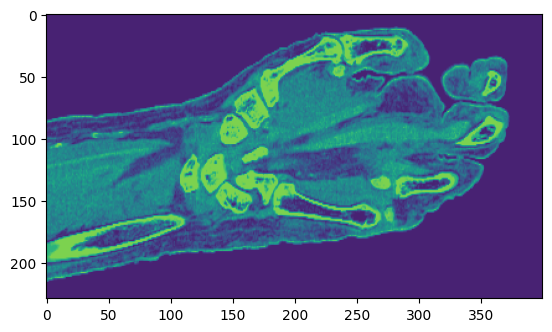

In [6]:
plt.imshow(test_phantom.get_complete()[0, 90, :, :], vmin=1500, vmax=2000)


In [7]:
num_transducers = 24
# transducers = [transducer.Planewave(max_frequency=0.5e6,
#                                     elements = 128, 
#                                     width = 40e-3,
#                                     height =  20e-3,
#                                     sensor_sampling_scheme = 'not_centroid', 
#                                     sweep = np.pi/16,
#                                     ray_num = 16, 
#                                     imaging_ndims = 2,
#                                     focus_elevation = 60e-3,
#                                     ) for i in range(num_transducers)]

transducers = [transducer.Focused(max_frequency = 1e6,
                                  elements = 128, 
                                  width = 10e-3,
                                  height =  10e-3,
                                  sensor_sampling_scheme = 'not_centroid', 
                                  sweep = np.pi/3,
                                  ray_num = 16,
                                  imaging_ndims = 2,
                                  focus_azimuth = 60-3,
                                  focus_elevation = 80-3) for i in range(num_transducers)]


for t in transducers:
    t.make_sensor_coords(1540) # test_phantom.baseline[0]

test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)

In [8]:
rotations = [geometry.Transform((r,0,0),(0,0,0)) for r in np.linspace(0, 2 * np.pi, num_transducers, endpoint=False)]
positions = [rot.apply_to_point((-0.06,0,0)) for rot in rotations]

for i in range(num_transducers):
    rotations[i].translation = positions[i]
    test_transducer_set.assign_pose(i, rotations[i])

In [9]:
test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='transmit_as_receive')
# test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='extended_aperture')

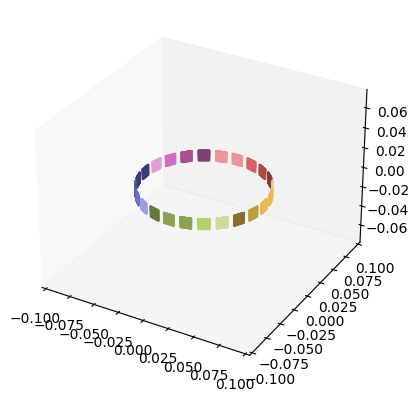

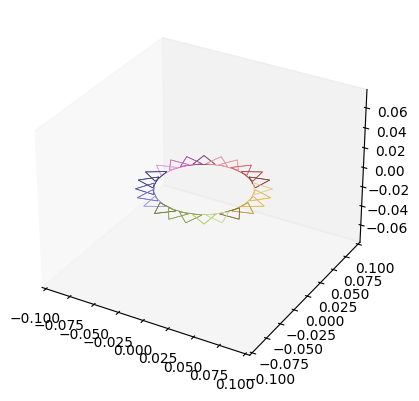

In [10]:
test_transducer_set.plot_transducer_coords()
test_transducer_set.plot_transducer_fovs()

In [11]:
simprops = simulation.SimProperties(
                grid_size   = (90e-3,20e-3,20e-3),
                voxel_size  = (0.5e-3,0.5e-3,0.5e-3),
                PML_size    = (32,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                grid_lambda = 2,               # 
                )

# simprops = simulation.SimProperties(
#                 grid_size   = (80e-3,130e-3,40e-3),
#                 voxel_size  = (0.5e-3,0.5e-3,0.5e-3),
#                 PML_size    = (32,8,8),
#                 PML_alpha   = 2,
#                 t_end       = 12e-5,           # [s]
#                 bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
#                 alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
#                 alpha_power = 1.5,
#                 grid_lambda = 2,               # 
#                 )

In [12]:
test_experiment = experiment.Experiment(
                 simulation_path = '../experiment_files/arm_experiment',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = test_transducer_set,
                 sensor          = test_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 5,
                 additional_keys = []
                 )

test_experiment.save()

workers specifies the number of simultaneous simulations running on a single gpu node, setting workers higher than 3 will likely use more RAM without decreasing overall runtime


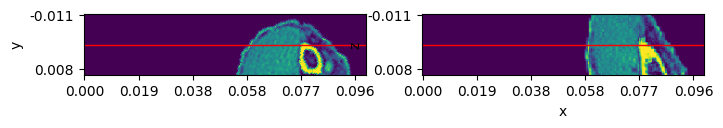

In [13]:
test_experiment.plot_ray_path(0)

In [14]:
test_experiment = experiment.Experiment.load('../experiment_files/arm_experiment')
test_experiment.run(dry=True)

dry run of simulation


100%|██████████| 24/24 [00:07<00:00,  3.33it/s]


In [15]:
test_experiment.run(repeat=True)

running with 5 workers

preparation for sim   96 completed in 13.03 seconds
preparation for sim  192 completed in 13.07 seconds
preparation for sim    0 completed in 13.39 seconds
preparation for sim  288 completed in 14.42 seconds
simulation            96 completed in  4.91 seconds
simulation           192 completed in  5.61 seconds
preparation for sim    1 completed in 12.71 seconds
preparation for sim   97 completed in 13.15 seconds
preparation for sim  193 completed in 13.61 seconds
preparation for sim  289 completed in 14.67 seconds
simulation             0 completed in  4.96 seconds
preparation for sim    2 completed in 11.25 seconds
simulation           288 completed in  4.80 seconds
simulation            97 completed in  4.71 seconds
simulation             1 completed in  4.92 seconds
simulation           193 completed in  4.91 seconds
preparation for sim  290 completed in 11.41 seconds
preparation for sim   98 completed in 11.68 seconds
preparation for sim  194 completed in 12

In [16]:
test_experiment.add_results()

In [17]:
test_reconstruction = reconstruction.DAS(experiment=test_experiment)
signals = test_reconstruction.get_signals(dimensions=2, matsize=128, downsample=0.5, workers=16, tgc=10)

100%|██████████| 384/384 [00:38<00:00, 10.07it/s]
24it [00:03,  6.22it/s]


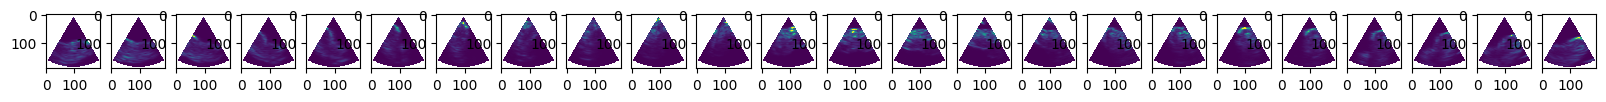

In [18]:
fig, ax = plt.subplots(1, len(test_reconstruction.transducer_set), figsize=(20, 5))
for i in range(len(test_reconstruction.transducer_set)):
    ax[i].imshow(signals[i], vmin=0, vmax=200000)

100%|██████████| 384/384 [00:36<00:00, 10.52it/s]
24it [00:03,  7.01it/s]


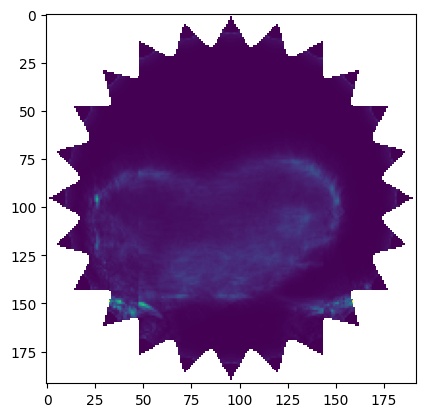

In [23]:
image = test_reconstruction.get_image(dimensions=2, matsize=128, downsample=0.5, workers=16, tgc=10)
plt.imshow(image, vmin=0, vmax=200000)

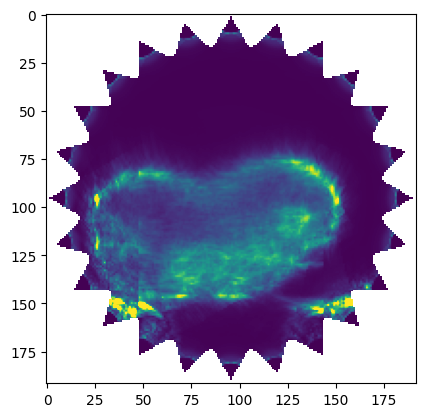

In [28]:
plt.imshow(image, vmin=0, vmax=50000)


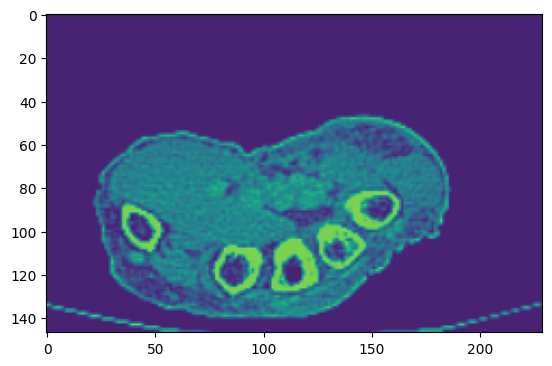

In [20]:
plt.imshow(test_phantom.get_complete()[0, :, :, 200], vmin=1500, vmax=2000)


In [21]:
# test_reconstruction = reconstruction.Compounding(experiment=test_experiment)
# images = test_reconstruction.compound(workers=24, resolution_multiplier=1, local=True, combine=True)

In [22]:
images.shape

NameError: name 'images' is not defined

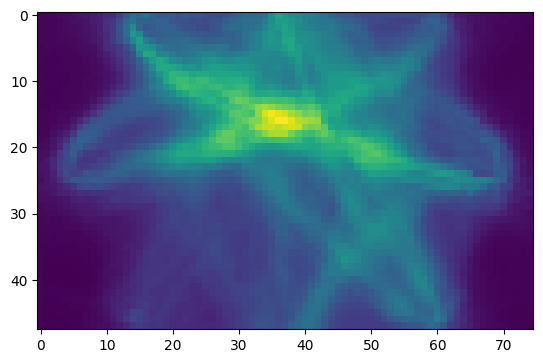

In [ ]:
plt.imshow(images[:, :, images.shape[2]//2])

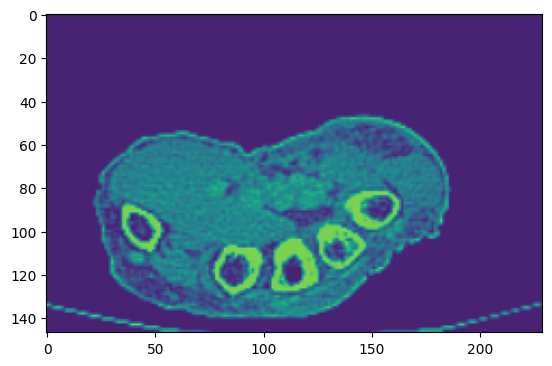

In [ ]:
plt.imshow(test_phantom.get_complete()[0, :, :, 200], vmin=1500, vmax=2000)


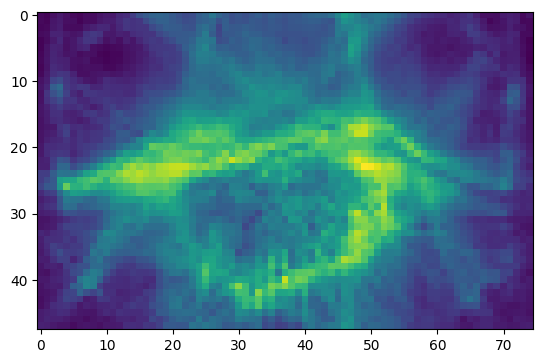

In [ ]:
plt.imshow(images[:, :, images.shape[2]//2])

In [ ]:
images.shape

(191, 298, 520)

In [ ]:
image = test_reconstruction.get_image(dimensions=2, matsize=128, downsample=0.5, workers=16, tgc=10)

100%|██████████| 512/512 [00:47<00:00, 10.75it/s]
8it [00:02,  2.74it/s]


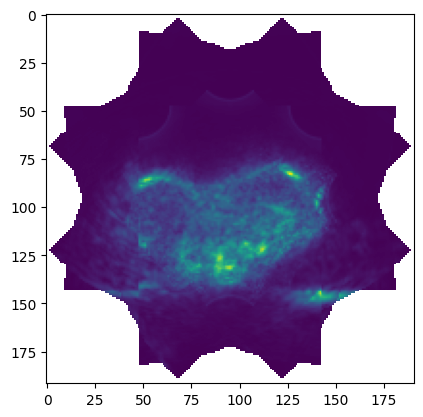

In [ ]:
plt.imshow(image)

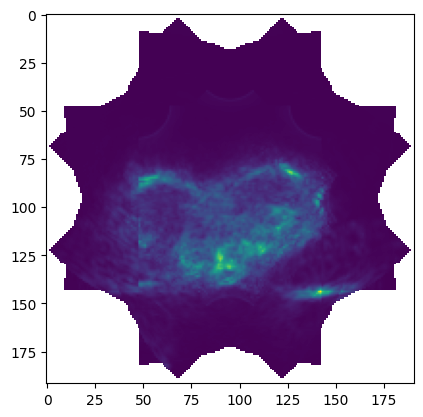

In [ ]:
plt.imshow(image)

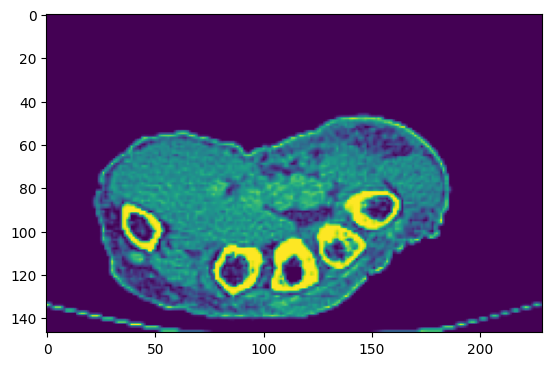

In [ ]:
plt.imshow(test_phantom.get_complete()[0, :, :, 200])


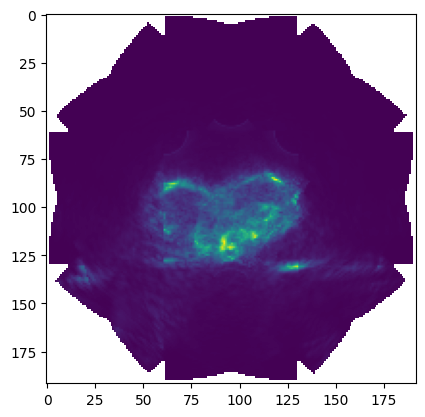

In [ ]:
plt.imshow(image)

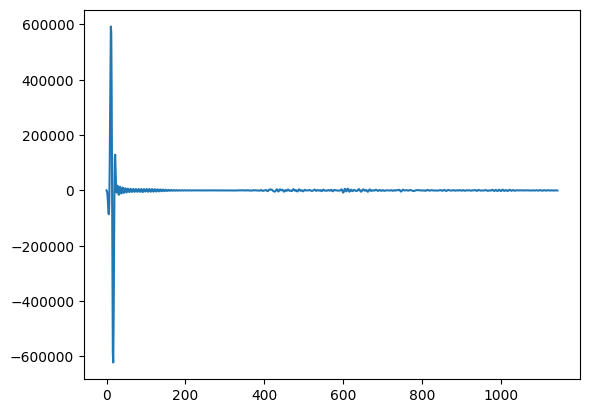

In [ ]:
plt.plot(test_experiment.results[9][1][0])

In [ ]:
test_experiment.results[0][1][0]

array([     0.        ,  -2221.76136719, -10400.96382813, ...,
         -429.7796405 ,   -428.60984253,    -85.30863785])